<a href="https://colab.research.google.com/github/Polar-Tsai/Fake_news_detecter/blob/main/0329_%E8%B2%93%E6%88%96%E7%8B%97_plot%26transfer_learning_gap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


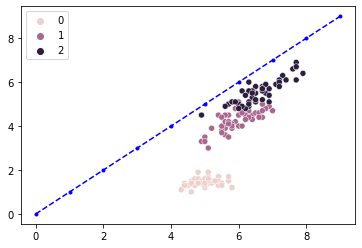

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
 
# plt.plot([0.1, 0.5, 0.3], [2, 5, 10])
iris = load_iris()
sl = iris["data"][:, 0] # ,0: 表示第0個
pl = iris["data"][:, 2]
sns.scatterplot(sl, pl, hue = iris["target"])
# 新增橫線
xs = np.array([i for i in range(10)])
ys = xs
plt.plot(xs, ys, ".--b") # ""可以改變圖的外觀
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html

## 遷移學習
* 用少少的資料，來建構模型
* 使用其他模型來建立類似的模型

### 步驟
1. 偷vgg16
2. 接上分類器
3. 訓練
>* 固定CNN參數，只調整分類器
>* 分類器調整好後，再微調CNN -> 可以不做


In [ ]:
# 解壓縮
import zipfile

path = "drive/MyDrive/程式語言學習/train.zip"
f = zipfile.ZipFile(path)
f.extractall()

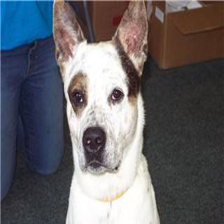

In [ ]:
# 觀看所有解壓縮檔案

import glob
from PIL import Image
fs = glob.glob("train/*")
Image.open(fs[4]).resize((224, 224)).convert("RGB") # 查閱指定圖片
# resize:尺寸要一致
# convert: 圖片顏色設定



In [ ]:
import pandas as pd
 
dog = glob.glob("train/dog.*")
cat = glob.glob("train/cat.*")
datas = pd.DataFrame({
    "path" : dog + cat,
    "ans" : [0] * len(dog) + [1] * len(cat)
})
datas

,path,ans
0,train/dog.3687.jpg,0
1,train/dog.2445.jpg,0
2,train/dog.5188.jpg,0
3,train/dog.6282.jpg,0
4,train/dog.3098.jpg,0
...,...,...
24995,train/cat.4144.jpg,1
24996,train/cat.7922.jpg,1
24997,train/cat.475.jpg,1
24998,train/cat.11280.jpg,1


In [ ]:
# 建立模型
# 偷模型
# keyword: keras.application
from tensorflow.keras.applications.vgg16 import VGG16

vgg = VGG16(include_top=False, input_shape=(224,224,3))
# include_top: 是否需要當初的mlp，假如我們要判斷的東西沒有在原本資料裡，要選擇False
# input_shape: 要填

58892288/58889256 [==============================] - 0s 0us/step


下游任務: 最後要執行的任務

In [ ]:
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

vgg_layers = vgg.layers

# vgg16模型
for l in vgg_layers:
  l.trainable = False

# 自製模型
clf_layers = [
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(2, activation="softmax") # 兩個以上softmax，一個sigmoid
]
model = Sequential(vgg_layers + clf_layers) # vgg16+自製模型
model.summary()


# Non-trainable params: 固定寫死，不可變動 
# >> 省時、CPU負擔小、可以用少量資料訓練

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [ ]:
# compile
from tensorflow.keras.losses import SparseCategoricalCrossentropy

model.compile(loss = SparseCategoricalCrossentropy(),
       optimizer = "adam",
       metrics = ["accuracy"])

In [ ]:
# demo pre: 我的預處理也要抄當初的預處理
# 所以，不需要/255
# https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py
import numpy as np
from tensorflow.keras.applications.vgg16 import preprocess_input
img = Image.open(fs[5000]).resize((224, 224)).convert("RGB")
img_np = np.array(img)
preprocess_input(img_np)

array([[[111.061     , 132.22101   , 130.32      ],
        [122.061     , 138.22101   , 121.32      ],
        [123.061     , 134.22101   ,  99.32      ],
        ...,
        [ 19.060997  ,   0.22100067,  -5.6800003 ],
        [ 18.060997  ,   2.2210007 ,  -4.6800003 ],
        [ 17.060997  ,   2.2210007 ,  -4.6800003 ]],

       [[117.061     , 134.22101   , 130.32      ],
        [121.061     , 137.22101   , 117.32      ],
        [105.061     , 116.221     ,  79.32      ],
        ...,
        [ 15.060997  ,  -3.7789993 ,  -9.68      ],
        [ 19.060997  ,   3.2210007 ,  -3.6800003 ],
        [ 19.060997  ,   4.2210007 ,  -2.6800003 ]],

       [[124.061     , 134.22101   , 128.32      ],
        [123.061     , 134.22101   , 113.32      ],
        [ 88.061     ,  93.221     ,  58.32      ],
        ...,
        [ 13.060997  ,  -5.7789993 , -11.68      ],
        [ 17.060997  ,   1.2210007 ,  -5.6800003 ],
        [ 17.060997  ,   2.2210007 ,  -4.6800003 ]],

       ...,

      

In [ ]:
# 提早轉換成陣列(np.array)
x, y = np.array(datas["path"]), np.array(datas["ans"])

In [ ]:
def get_data(x, y, batch=20): # 每20張圖片訓練一次
  # x, y = datas["path"], datas["ans"]
  idx = np.random.randint(0, len(x), size=batch)
  # 最大值不包含!!
  # size: 2組3行
  y_batch = y[idx]
  x_batch, x_batch_ori = [], []
  for p in x[idx]:
    img = Image.open(p).resize((224, 224)).convert("RGB")
    img_np = np.array(img)
    img_np_pre = preprocess_input(img_np)
    x_batch.append(img_np_pre)
    x_batch_ori.append(img_np)
  return (np.array(x_batch), np.array(y_batch), np.array(x_batch_ori)) # 圖片/答案/原始圖片

x_batch, y_batch, x_batch_ori = get_data(x, y)
print(x_batch.shape)
print(y_batch.shape)
print(x_batch.shape)

(20, 224, 224, 3)
(20,)
(20, 224, 224, 3)


In [ ]:
# train
# train_on_batch: 批次訓練
for i in range(20): # 循環操作幾次
  print("-" * 15, i, "-" * 15)
  x_batch, y_batch, x_batch_ori = get_data(x, y)
  result = model.train_on_batch(x_batch, y_batch)
  print("[Train]:", result)
  x_batch, y_batch, x_batch_ori = get_data(x, y)
  result = model.test_on_batch(x_batch, y_batch)
  print("[Validate]:", result)

# loss, accuracy

--------------- 0 ---------------
[Train]: [0.7435277700424194, 0.5]
[Validate]: [2.377701759338379, 0.6000000238418579]
--------------- 1 ---------------
[Train]: [0.5929163694381714, 0.6499999761581421]
[Validate]: [3.1913771629333496, 0.5]
--------------- 2 ---------------
[Train]: [0.8459488749504089, 0.3499999940395355]
[Validate]: [2.5843868255615234, 0.550000011920929]
--------------- 3 ---------------
[Train]: [0.7045300006866455, 0.6499999761581421]
[Validate]: [1.7430871725082397, 0.6499999761581421]
--------------- 4 ---------------
[Train]: [0.6027928590774536, 0.800000011920929]
[Validate]: [1.6876227855682373, 0.6000000238418579]
--------------- 5 ---------------
[Train]: [0.6835764050483704, 0.6499999761581421]
[Validate]: [0.9650728106498718, 0.699999988079071]
--------------- 6 ---------------
[Train]: [0.450702428817749, 0.8999999761581421]
[Validate]: [1.2563798427581787, 0.6000000238418579]
--------------- 7 ---------------
[Train]: [0.5352140665054321, 0.75]
[Valid

In [ ]:
model.predict(x_batch)


array([[4.5996046e-01, 5.4003954e-01],
       [5.7888955e-02, 9.4211107e-01],
       [9.3963575e-03, 9.9060363e-01],
       [5.2754337e-01, 4.7245663e-01],
       [2.4235405e-01, 7.5764602e-01],
       [5.3740108e-01, 4.6259892e-01],
       [9.6298581e-01, 3.7014131e-02],
       [9.2729144e-03, 9.9072707e-01],
       [1.1732265e-02, 9.8826772e-01],
       [2.0892368e-01, 7.9107630e-01],
       [6.3619155e-01, 3.6380842e-01],
       [1.9907942e-02, 9.8009205e-01],
       [2.0609613e-01, 7.9390383e-01],
       [1.1079007e-01, 8.8920993e-01],
       [6.5241382e-04, 9.9934763e-01],
       [7.6406062e-01, 2.3593931e-01],
       [8.6277461e-01, 1.3722543e-01],
       [2.5077231e-02, 9.7492278e-01],
       [1.7001954e-03, 9.9829978e-01],
       [8.1796281e-04, 9.9918205e-01]], dtype=float32)

In [ ]:
x_batch, y_batch, x_batch_ori = get_data(x, y, 2000)
model.evaluate(x_batch, y_batch)

63/63 [==============================] - 17s 178ms/step - loss: 0.3569 - accuracy: 0.8355


[0.35688015818595886, 0.8355000019073486]

# 出現許多值都是0or1，代表模型有問題
# 理想狀態應該是介於中間值
# >>>可能代表偷的模型用的是caffe，無法滿足我們的需求，這時要使用normalize

Batch Normalization(移植器官後，服用的轉嫁藥物)
1. 觀察最後的捲積是多少(7, 7, 512)，有20層
2. 每層挑出同一順序的R、G、B做nor.
標準差: 每個點與平均的距離再平均
3. 對一張特徵圖(那20層)求平均、標準差，共有512組平均、標準差
4. 除掉之後，Xnew(平均=0，標準差=1)
達以上階段就可以使用tensorflow
5. 若RGB都為平均=0，標準差=1，可能會消弭掉他們之間的相互關係>>無理!
6. 優化: 平均、標準差利用【負斜率】手動取得優化值
7. 答案: **優化標準差*Xnew+優化平均**

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


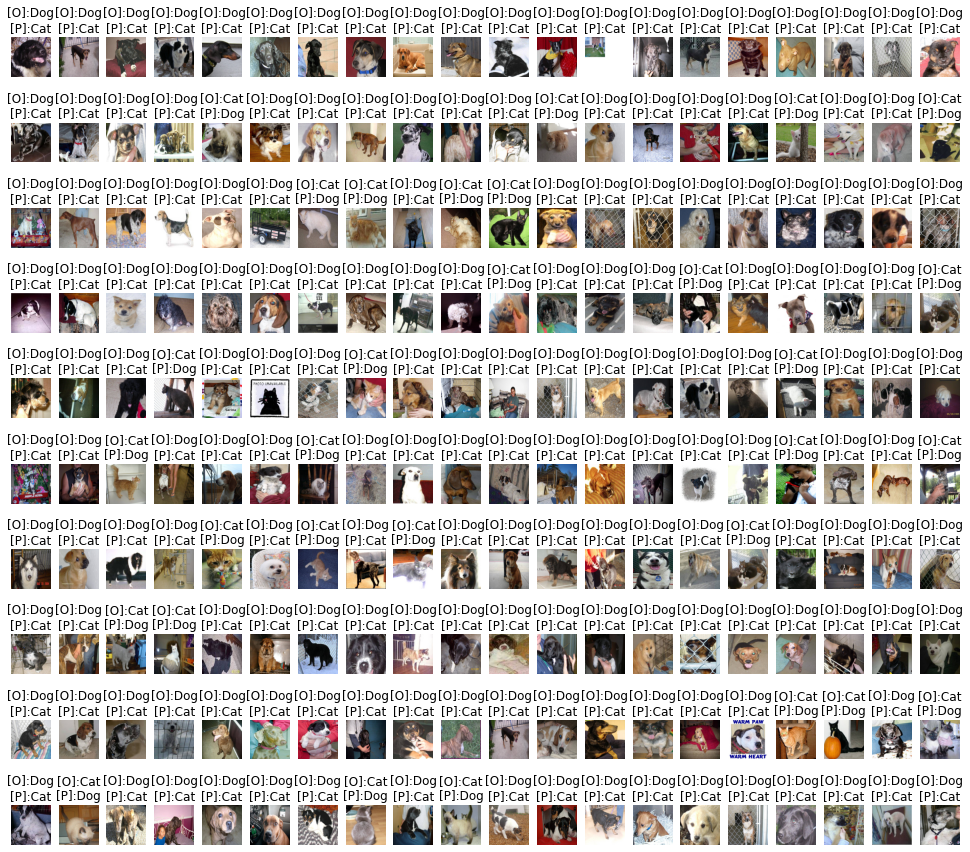

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

pre = model.predict_classes(x_batch)
trans = ["Dog", "Cat"]
idx = np.nonzero(pre != y_batch)[0][:200]
false_img = x_batch_ori[idx]
false_pre = pre[idx]
false_label = y_batch[idx]
plt.figure(figsize=(17, 17))
width = 20
height = len(idx) // width + 1
for i in range(len(idx)):
    plt.subplot(height, width, i+1)
    t = "[O]:{}\n[P]:{}".format(trans[false_label[i]], trans[false_pre[i]])
    plt.title(t)
    plt.axis("off")
    plt.imshow(false_img[i])

url:https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSwqt6OoAa-_5kOrTK6FvYK9fuJGAN3sav3G4NMrx9QLUN2InSsxjfUB4Feotr7Pxz3faJXETk&usqp=CAc


/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Dog 的機率: 0.57173866
Cat 的機率: 0.42826137
答案: Dog


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


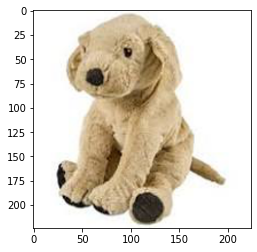

In [ ]:
# Pillow
import requests
from PIL import Image
# RGB, RGBA, L(gray)
url = input("url:")
headers = {
  "user-agent":"user-agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.90 Safari/537.36"  
}
response = requests.get(url, headers=headers, stream=True, verify=False)
img = Image.open(response.raw).resize((224, 224)).convert("RGB")
img_np = np.array(img)
img_np_r = preprocess_input(img_np.reshape(1, 224, 224, 3))
proba = model.predict(img_np_r)[0]
for i, p in enumerate(proba):
    print(trans[i], "的機率:", p)
ans = model.predict_classes(img_np_r)[0]
print("答案:", trans[ans])
plt.imshow(img_np)